In [2]:
import pandas as pd
import numpy as np
import codecs
import konlpy
from konlpy.tag import Okt
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer 
from keras.layers import Embedding, Dense, LSTM 
from keras.models import Sequential 
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


### Data import

In [3]:
train_new=pd.read_csv('./TEST_train_newlabel.csv', encoding='utf-8',index_col=False)
test_new=pd.read_csv('./TEST_test_newlabel.csv', encoding='utf-8',index_col=False)

In [4]:
# 10만개만 추출
train_new=train_new.iloc[:100000,:] # 14500

In [5]:
train_new

,Unnamed: 0,title,newlabel
0,0,"<유>한성기업, 전일 대비 7.51% 상승.. 일일회전율은 2.20% 기록 ...",0
1,1,"기업회원 87.2％ ""정부 및 지자체의 소상공인 지원 환영""<알바천국> ...",0
2,2,"태국, 세 번째 비상사태 연장에 ""코로나 때문 vs 정치적 목적"" ...",0
3,3,"[포토] 서울농협, GKL 임직원과 농촌봉사활동 ...",1
4,4,"현대차, 군사 부문 수소전기차,충전소 보급 확대 ...",0
...,...,...,...
99995,99995,"인천·속초·수원, '스마트관광 도시' 후보지로 선정 ...",0
99996,99996,"'케어젠' 52주 신고가 경신, 전일 기관 대량 순매수 ...",0
99997,99997,"홈플러스, ‘시그니처 캔커피’ 출시 2주만에 25만개 돌파 ...",1
99998,99998,안동 등 경북 3곳 폭염주의보 ...,0


### Data preprocessing

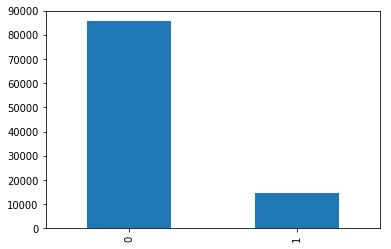

In [6]:
%matplotlib inline 
import matplotlib.pyplot as plt

train_new['newlabel'].value_counts().plot(kind='bar')

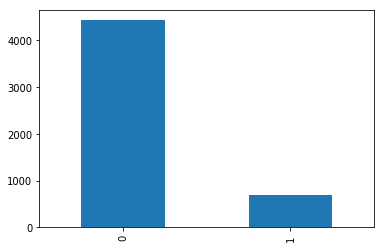

In [7]:
test_new['newlabel'].value_counts().plot(kind='bar')

In [8]:
print(train_new.groupby('newlabel').size().reset_index(name='count')) 
print(test_new.groupby('newlabel').size().reset_index(name='count'))

   newlabel  count
0         0  85529
1         1  14471
   newlabel  count
0         0   4431
1         1    700


#### 불용어 제거

In [9]:
stopwords = ['의', '가', '이', '은', '들', '는', '좀', '잘', '과', '도', '를', '으로', '자', '에', '와', '한', '하다']

In [10]:
# 형태소 추출 후 불용어 제거
okt = Okt()
X_train = [] 
for sentence in train_new['title']: 
    temp_X = [] 
    temp_X = okt.morphs(sentence, stem=True) # 토큰화 
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거 
    X_train.append(temp_X)
X_test = [] 
for sentence in test_new['title']: 
    temp_X = [] 
    temp_X = okt.morphs(sentence, stem=True) # 토큰화 
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거 
    X_test.append(temp_X)

#### 토큰화: 단어들에 고유 번호 부여, 계산 처리하기 용이하기 때문

In [11]:
# 정수 인코딩
max_words = 35000 
tokenizer = Tokenizer(num_words = max_words) 
tokenizer.fit_on_texts(X_train) 
X_train = tokenizer.texts_to_sequences(X_train) 
X_test = tokenizer.texts_to_sequences(X_test)

#### 각 데이터 별 제목 최대 길이 추출 -> input 길이를 맞춰야 함

제목의 최대 길이 :  50
제목의 평균 길이 :  12.78352


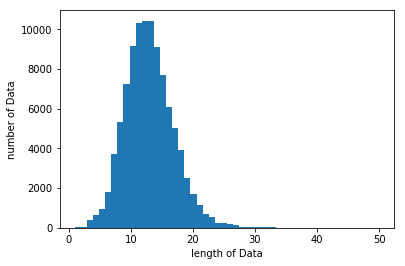

In [12]:
# train
print("제목의 최대 길이 : ", max(len(l) for l in X_train)) 
print("제목의 평균 길이 : ", sum(map(len, X_train))/ len(X_train)) 
plt.hist([len(s) for s in X_train], bins=50) 
plt.xlabel('length of Data') 
plt.ylabel('number of Data') 
plt.show()

제목의 최대 길이 :  30
제목의 평균 길이 :  12.796530890664588


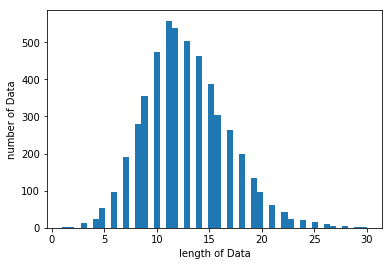

In [13]:
# test
print("제목의 최대 길이 : ", max(len(l) for l in X_test)) 
print("제목의 평균 길이 : ", sum(map(len, X_test))/ len(X_test)) 
plt.hist([len(s) for s in X_test], bins=50) 
plt.xlabel('length of Data') 
plt.ylabel('number of Data') 
plt.show()

In [14]:
# y값 one-hot encoding
import numpy as np 
y_train = [] 
y_test = [] 
for i in range(len(train_new['newlabel'])): 
    if train_new['newlabel'].iloc[i] == 1: 
        y_train.append([0, 1]) 
    elif train_new['newlabel'].iloc[i] == 0: 
        y_train.append([1, 0]) 
        
y_train = np.array(y_train) 


for i in range(len(test_new['newlabel'])): 
    if test_new['newlabel'].iloc[i] == 1: 
        y_test.append([0, 1]) 
    elif test_new['newlabel'].iloc[i] == 0: 
        y_test.append([1, 0]) 

y_test = np.array(y_test)

In [15]:
max_len = 50 # 제목 길이 50으로 맞추기 
X_train = pad_sequences(X_train, maxlen=max_len) 
X_test = pad_sequences(X_test, maxlen=max_len)

### Modeling

In [18]:
import warnings
warnings.filterwarnings('ignore')
# Early Stopping 추가
from keras.callbacks import EarlyStopping
import tensorflow as tf
from sklearn.metrics import roc_auc_score

model = Sequential() 
model.add(Embedding(max_words, 100)) 
model.add(LSTM(128)) 
model.add(Dense(2, activation='softmax')) 
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 
early_stopping = EarlyStopping() 
history = model.fit(X_train, y_train, epochs=10, batch_size=3000, validation_split=0.1, callbacks=[early_stopping])

Train on 90000 samples, validate on 10000 samples
Epoch 1/10
90000/90000 [==============================] - 72s 802us/step - loss: 0.4632 - acc: 0.8409 - val_loss: 0.3301 - val_acc: 0.8580
Epoch 2/10
90000/90000 [==============================] - 70s 779us/step - loss: 0.2422 - acc: 0.8976 - val_loss: 0.1825 - val_acc: 0.9350
Epoch 3/10
90000/90000 [==============================] - 74s 825us/step - loss: 0.1122 - acc: 0.9613 - val_loss: 0.0897 - val_acc: 0.9693
Epoch 4/10
90000/90000 [==============================] - 71s 787us/step - loss: 0.0328 - acc: 0.9913 - val_loss: 0.0450 - val_acc: 0.9884
Epoch 5/10
90000/90000 [==============================] - 70s 781us/step - loss: 0.0110 - acc: 0.9974 - val_loss: 0.0379 - val_acc: 0.9904
Epoch 6/10
90000/90000 [==============================] - 77s 856us/step - loss: 0.0055 - acc: 0.9989 - val_loss: 0.0365 - val_acc: 0.9921
Epoch 7/10
90000/90000 [==============================] - 73s 812us/step - loss: 0.0036 - acc: 0.9992 - val_loss: 0.

### epoch 별 loss

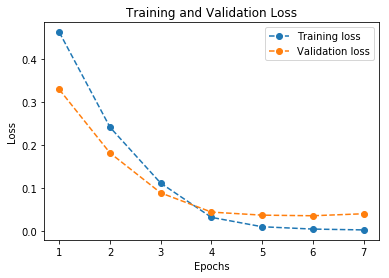

In [20]:
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, linestyle='--', marker='o', label='Training loss')  # ‘bo’는 점을 의미합니다.
plt.plot(epochs, val_loss, linestyle='--', marker='o',  label='Validation loss') # ‘b’는 실선을 의미합니다.
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
fig = plt.gcf()
fig.savefig('loss_3000.png')
plt.show()


### epoch 별 accuracy

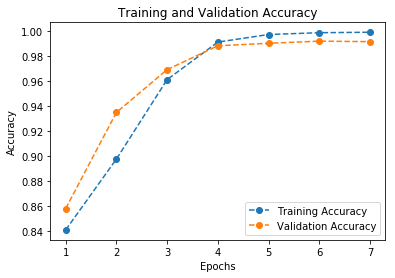

In [21]:
plt.clf()
acc = history_dict['acc']
val_acc = history_dict['val_acc']

plt.plot(epochs, acc, linestyle='--', marker='o', label='Training Accuracy')  
plt.plot(epochs, val_acc, linestyle='--', marker='o',  label='Validation Accuracy') 

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
fig = plt.gcf()
#fig.savefig('accuracy_3000.png')
plt.show()

## Model Evaluation

In [23]:
loss_and_metrics = model.evaluate(X_test, y_test, batch_size=2000)

5131/5131 [==============================] - 1s 231us/step


### Prediction

In [30]:
predict = model.predict(X_test)
import numpy as np 
predict_labels = np.argmax(predict, axis=1) 
original_labels = np.argmax(y_test, axis=1)

In [31]:
sum(predict_labels==original_labels)/len(predict_labels)

0.9912297797700254

In [32]:
from sklearn.metrics import confusion_matrix

y_true = original_labels
y_pred = predict_labels

confusion_matrix(y_true, y_pred)

array([[4416,   15],
       [  30,  670]], dtype=int64)

### Classification report

In [33]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=['normal', 'spam']))

              precision    recall  f1-score   support

      normal       0.99      1.00      0.99      4431
        spam       0.98      0.96      0.97       700

    accuracy                           0.99      5131
   macro avg       0.99      0.98      0.98      5131
weighted avg       0.99      0.99      0.99      5131

